DBSCAN
======

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
%matplotlib inline

Consider the following two-dimensional dataset

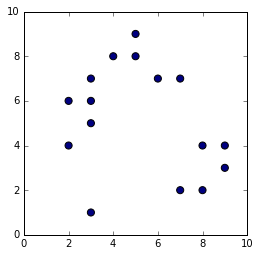

In [112]:
dataset = np.array([
    (2, 4), (2, 6), (3, 1), (3, 5),
    (3, 6), (3, 7), (4, 8), (5, 8),
    (5, 9), (6, 7), (7, 2), (7, 7),
    (8, 2), (8, 4), (9, 3), (9, 4),
])
boundary = max(dataset[:,0].max(), dataset[:,1].max()) + 1

plt.axis([0, boundary, 0, boundary])
plt.axes().set_aspect('equal')
plt.scatter(dataset[:,0], dataset[:,1], c=np.ones(len(dataset)), s=50)
plt.show()

Determine input parameters
------------------------------
Use the k-distance heuristic to determine input parameters MinPts and epsilon for DBSCAN using the Manhattan distance. The heuristic works by fixing MinPts = 2*d-1 (d = dimensions of data space, so MinPts = 3 in this case) and determining the k-NN distance for each point.

In [30]:
def manhattan_distance(a, b):
    return np.abs(a-b).sum()

def euclidean_distance(a, b):
    return np.linalg.norm(a-b)

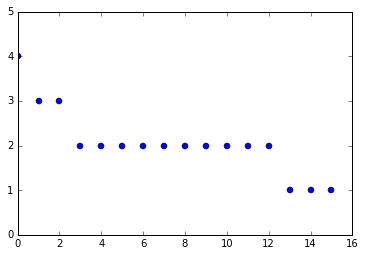

In [50]:
def knn_distance(point, dataset, k=3, metric=manhattan_distance):
    if not k:
        return 0
    # k-NN could be retrieved using r-tree to increase effiency
    distances = [metric(point, point2) for point2 in dataset]
    return np.sort(distances)[k-1]

# retrieve and plot epsilon for each object
epsilons = []
for point in dataset:
    epsilons.append(knn_distance(point, dataset))
epsilons = np.sort(epsilons)[::-1]

plt.axis([0, len(dataset), 0, np.max(epsilons)+1])
plt.plot(epsilons, 'o')

Choose epsilon = knn_distance(o) such that o is the border object of the least dense cluster in our dataset, i.e. epsilon = 2 in this case.

Apply DBSCAN
--------------

Apply DBSCAN to the given data set using the Euclidean distance, MinPts = 4 and epsilon = 2.2. Give the resulting clusters as sets of points and a list of all core objects

cluster (9, 3)
assign (8, 2) 1
expand (8, 2)
assign (7, 2) 1
assign (8, 4) 1
expand (8, 4)
assign (9, 4) 1
assign (9, 4) 1
cluster (5, 8)
assign (4, 8) 2
expand (4, 8)
assign (3, 7) 2
expand (3, 7)
assign (2, 6) 2
expand (2, 6)
assign (2, 4) 2
assign (3, 5) 2
expand (3, 5)
assign (2, 4) 2
assign (3, 6) 2
expand (3, 6)
assign (5, 9) 2
assign (5, 9) 2
assign (6, 7) 2


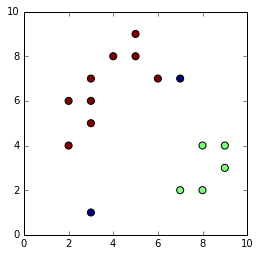

In [181]:
class DBSCAN:
    
    def __init__(self, epsilon, min_points, metric):
        self.epsilon = epsilon
        self.min_points = min_points
        self.metric = metric
        self.dataset = None
        self.assignment = None
        self.unvisited = None
    
    def __call__(self, dataset):
        """Returns a vector of cluster indizes for every point in the dataset
        with cluster 0 containing noise."""
        self.dataset = [tuple(p) for p in dataset]
        self.unvisited = [tuple(p) for p in dataset]
        self.assignment = {}
        cluster_index = 0
        while len(self.unvisited):
            point = self.unvisited.pop()
            neighbours = self._neighbours(point)
            if self._is_core(point, neighbours):
                print("cluster", point)
                cluster_index += 1
                self.assignment[point] = cluster_index
                self._collect(neighbours, cluster_index, [point])
            else:
                self.assignment[point] = 0
        return np.array([self.assignment[x] for x in self.dataset])
    
    def _collect(self, points, cluster_index, closure):
        """Recursively expands the cluster by collecting all density-reachable
        points in a transitive closure. The closure initially only contains
        the core object that was selected as a representative."""
        for point in points:
            if point in closure:
                continue
            print("assign", point, cluster_index)
            self.assignment[point] = cluster_index
            if point in self.unvisited:
                self.unvisited.remove(point)
            neighbours = self._neighbours(point)
            if self._is_core(point, neighbours):
                print("expand", point)
                closure.append(point)
                self._collect(neighbours, cluster_index, closure)
    
    def _neighbours(self, point):
        neighbours = []
        for point2 in self.dataset:
            if point == point2:
                continue
            if self.metric(np.array(point), np.array(point2)) <= self.epsilon:
                neighbours.append(point2)
        return neighbours
    
    def _is_core(self, point, neighbours):
        # plus one for point itself
        return len(neighbours) + 1 >= self.min_points

assignment = DBSCAN(epsilon=2.2, min_points=4, metric=euclidean_distance)(dataset)

plt.axis([0, boundary, 0, boundary])
plt.axes().set_aspect('equal')
plt.scatter(dataset[:,0], dataset[:,1], c=assignment, s=50)
plt.show()